In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")
df = df.drop(columns=["OutcomeSubtype","AnimalID"])
target = "OutcomeType"

In [3]:
target_dict = {
    "Adoption": 0,
"Transfer": 1,
"Return_to_owner": 2, 
"Euthanasia":3,
"Died":4
}

In [4]:
df[target] = df[target].map(target_dict)

## EDA

In [5]:
df.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,2,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,3,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,0,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,1,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,1,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [6]:
df.shape

(26729, 8)

In [7]:
(df.isna().sum()/df.shape[0]).sort_values()

DateTime          0.000000
OutcomeType       0.000000
AnimalType        0.000000
Breed             0.000000
Color             0.000000
SexuponOutcome    0.000037
AgeuponOutcome    0.000673
Name              0.287740
dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 8 columns):
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null int64
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: int64(1), object(7)
memory usage: 1.6+ MB


In [9]:
df.nunique()

Name               6374
DateTime          22918
OutcomeType           5
AnimalType            2
SexuponOutcome        5
AgeuponOutcome       44
Breed              1380
Color               366
dtype: int64

In [10]:
for cl in df.columns:
    print(cl)
    print(df[cl].value_counts())
    print("\n")

Name
Max             136
Bella           135
Charlie         107
Daisy           106
Lucy             94
               ... 
Karli             1
Mabry             1
Dev               1
Akiko (Snow)      1
Phantom           1
Name: Name, Length: 6374, dtype: int64


DateTime
2015-08-11 00:00:00    19
2015-11-17 00:00:00    17
2015-07-02 00:00:00    13
2015-04-02 00:00:00    11
2014-08-31 09:00:00    10
                       ..
2014-05-23 13:42:00     1
2013-12-30 07:44:00     1
2013-11-16 12:52:00     1
2015-10-24 17:37:00     1
2013-11-07 13:02:00     1
Name: DateTime, Length: 22918, dtype: int64


OutcomeType
0    10769
1     9422
2     4786
3     1555
4      197
Name: OutcomeType, dtype: int64


AnimalType
Dog    15595
Cat    11134
Name: AnimalType, dtype: int64


SexuponOutcome
Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64


AgeuponOutcome
1 year       3969
2 years      3742
2 months 

## preprocessing

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(columns=target),df[target], 
                 test_size=0.3, random_state=42, stratify=df[target])

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import TransformerMixin

In [56]:
class SimpleImputerDf(SimpleImputer):
    """DataFrame Wrapper around SimpleImputer"""
    def __init__(self, strategy):
        super(SimpleImputerDf, self).__init__(strategy=strategy)

    def fit(self, X, y=None):
        if len(X.values.shape)==1:
            vals = X.values.reshape(-1,1)
        else:
            vals = X.values    
        return super(SimpleImputerDf, self).fit(vals)
    
    def transform(self, X, y=None):
        if len(X.values.shape)==1:
            vals = X.values.reshape(-1,1)
            names = [X.name]
        else:
            vals = X.values
            names = X.columns
        z = super(SimpleImputerDf, self).transform(vals)
        return pd.DataFrame(z, index=X.index, columns=names)
    
class OrdinalEncoderDf(OrdinalEncoder):
    """DataFrame Wrapper around OrdinalEncoderDf"""
    def __init__(self):
        super(OrdinalEncoderDf, self).__init__()

    def transform(self, X, y=None):
        z = super(OrdinalEncoderDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [57]:
# преобразуем поля пола и типа животного
# нет необходимости использовать one hot encoder, так как дерево за нас сделает необходимые разбивки
features_1 = Pipeline([
    ("get features", FunctionTransformer(lambda x: x[["AnimalType", "SexuponOutcome"]])),
    ("impute", SimpleImputerDf(strategy="most_frequent")),
    ("encode", OrdinalEncoderDf())
])

In [58]:
# преобразуем дату в набор год/месяц/день недели
def create_time_features(df):
    dt = pd.to_datetime(df.iloc[:,0])
    return pd.DataFrame([dt.dt.year.rename("yr"), dt.dt.month.rename("mn"), dt.dt.weekday.rename("weekday")]).T

features_2 = Pipeline([
    ("get features", FunctionTransformer(lambda x: x["DateTime"])),
    ("impute", SimpleImputerDf(strategy="most_frequent")),
    ("create_time_features", FunctionTransformer(create_time_features))
])

In [59]:
# преобразуем AgeuponOutcome в числовую переменную
# преобразуем дату в набор год/месяц/день недели
def preprocess_ageuponoutcome(df):
    sr = df.iloc[:,0]
    dct = {
        'weeks':7,
        'years':365, 
        'months':30, 
        'year':365, 
        'days':1, 
        'month':30, 
        'week':7, 
        'day':1        
    }    
    return (sr.apply(lambda x:str(x).split()[1]).map(dct) * sr.apply(lambda x: int(str(x).split()[0])) ).values.reshape(-1,1)

features_3 = Pipeline([
    ("get features", FunctionTransformer(lambda x: x["AgeuponOutcome"])),
    ("impute", SimpleImputerDf(strategy="most_frequent")),
    ("calculate", FunctionTransformer(preprocess_ageuponoutcome)),
])

In [154]:
# прочие переменные преобразуем с помощью Count Encoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from category_encoders import TargetEncoder, CountEncoder
features_4 = Pipeline([
    ("get features", FunctionTransformer(lambda x: x.loc[:,["Breed", "Name", "Color"]])),
    ("impute", SimpleImputerDf(strategy="most_frequent")),
#     ("vectorize", TfidfVectorizer(ngram_range = (1,2), max_features=40)),
    ("encode", CountEncoder(handle_unknown=0, min_group_size=0.05)),
#     ("to_dense", FunctionTransformer(lambda x: x.todense())),
#     ("dense", DenseTransformer())
])

In [155]:
preprocessing_pipeline = FeatureUnion([
    ("1", features_1),
    ("2", features_2),
    ("3", features_3),
    ("4", features_4),    

])

column_names = ["AnimalType", "SexuponOutcome",
             "yr","mn", "weekday",
             "AgeuponOutcome",
             "Breed", "Name", "Color"
            ]

pd.DataFrame(preprocessing_pipeline.fit_transform(X_train), columns=column_names).head()

,AnimalType,SexuponOutcome,yr,mn,weekday,AgeuponOutcome,Breed,Name,Color
0,0.0,2.0,2013.0,11.0,5.0,60.0,6186.0,1.0,1561.0
1,1.0,1.0,2015.0,7.0,3.0,30.0,1342.0,5452.0,485.0
2,0.0,1.0,2015.0,8.0,1.0,21.0,18.0,5452.0,25.0
3,0.0,2.0,2013.0,11.0,3.0,365.0,272.0,7.0,60.0
4,0.0,2.0,2015.0,12.0,3.0,1825.0,6186.0,4.0,310.0


## Моделирование

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report


In [157]:
model = RandomForestClassifier()
baseline = DummyClassifier(strategy ="stratified")

In [158]:
pl = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("model", model) 
])
pl.fit(X_train, y_train)
y_predicted = pl.predict(X_test)

In [159]:
baseline.fit(X_train, y_train)
y_predicted_baseline = baseline.predict(X_test)

In [160]:
print("baseline")
print(classification_report(y_test, y_predicted_baseline, target_names =target_dict.keys()))
print("model")
print(classification_report(y_test, y_predicted, target_names =target_dict.keys()))

baseline
                 precision    recall  f1-score   support

       Adoption       0.41      0.42      0.41      3231
       Transfer       0.37      0.36      0.36      2827
Return_to_owner       0.18      0.18      0.18      1436
     Euthanasia       0.04      0.04      0.04       466
           Died       0.00      0.00      0.00        59

       accuracy                           0.33      8019
      macro avg       0.20      0.20      0.20      8019
   weighted avg       0.33      0.33      0.33      8019

model
                 precision    recall  f1-score   support

       Adoption       0.68      0.81      0.74      3231
       Transfer       0.71      0.65      0.68      2827
Return_to_owner       0.46      0.44      0.45      1436
     Euthanasia       0.55      0.21      0.30       466
           Died       0.33      0.03      0.06        59

       accuracy                           0.65      8019
      macro avg       0.55      0.43      0.45      8019
   weighted

## Видим, что модель гораздо круче базовой линии. Подберем параметры классификатотра и еще раз посмотрим на результат

In [166]:
%%time
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'model__max_depth': [None, 2,3,5,10,15,20,30,40],
#     'model__min_samples_leaf': [1,2,5,10,0.01,0.05,0.1,0.2],
    'model__n_estimators': np.logspace(0.5,4,20).astype(int)
}
search = RandomizedSearchCV(pl, param_grid, n_jobs=-1, cv=5, verbose=1,n_iter=20)
search.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 239.1min finished


Wall time: 4h 2min 16s


{'model__n_estimators': 6543, 'model__max_depth': 10}

In [168]:
pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,129.520371,1.079117,10.787546,0.701938,6543,10,"{'model__n_estimators': 6543, 'model__max_dept...",0.648316,0.657937,0.654730,0.658739,0.661945,0.656334,0.004619,1
2,3.095132,0.283538,0.455981,0.050447,26,10,"{'model__n_estimators': 26, 'model__max_depth'...",0.646980,0.659808,0.654997,0.653394,0.652325,0.653501,0.004146,2
8,8.792935,0.361703,0.700872,0.023948,219,15,"{'model__n_estimators': 219, 'model__max_depth...",0.646446,0.652859,0.650722,0.654196,0.656334,0.652111,0.003369,3
1,2.931163,0.046729,0.567074,0.026694,11,10,"{'model__n_estimators': 11, 'model__max_depth'...",0.650989,0.650989,0.647782,0.652325,0.656066,0.651630,0.002676,4
18,20.878755,0.066359,1.287158,0.056542,784,15,"{'model__n_estimators': 784, 'model__max_depth...",0.644575,0.652325,0.649385,0.654463,0.656066,0.651363,0.004066,5


## на мой вззгляд самая приличная модель у нас на 4 месте - высокий уровень метрики при низком среднеквадратическом отклоннии. При этом глубина модельки маленькая, она быстро обучается. Поищем оптимальное решение в окрестности найденных параметров

In [171]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__max_depth': [8,9,10,11,12],
#     'model__min_samples_leaf': [1,2,5,10,0.01,0.05,0.1,0.2],
    'model__n_estimators': [8,9,10,11,12]
}
search = GridSearchCV(pl, param_grid, n_jobs=-1, cv=5, verbose=1)
search.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.5min finished


Wall time: 1min 37s


{'model__max_depth': 10, 'model__n_estimators': 12}

In [186]:
print("модель с подобранными параметрами")
y_predicted = search.predict(X_test)
print(classification_report(y_test, y_predicted, target_names =target_dict.keys()))

модель с подобранными параметрами
                 precision    recall  f1-score   support

       Adoption       0.66      0.85      0.74      3231
       Transfer       0.74      0.64      0.69      2827
Return_to_owner       0.48      0.44      0.46      1436
     Euthanasia       0.67      0.13      0.22       466
           Died       0.00      0.00      0.00        59

       accuracy                           0.65      8019
      macro avg       0.51      0.41      0.42      8019
   weighted avg       0.65      0.65      0.64      8019



C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [245]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[2692,  221,  317,    1,    0],
       [ 661, 1834,  297,   35,    0],
       [ 607,  182,  639,    8,    0],
       [  56,  239,  102,   69,    0],
       [   3,   55,    0,    1,    0]], dtype=int64)

In [187]:
### что-то качество не приросло

In [173]:
pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,2.206297,0.016860,0.377591,0.020840,10,12,"{'model__max_depth': 10, 'model__n_estimators'...",0.646980,0.660075,0.652058,0.654730,0.656601,0.654089,0.004409,1
13,2.210486,0.017488,0.368017,0.015668,10,11,"{'model__max_depth': 10, 'model__n_estimators'...",0.652859,0.653127,0.648851,0.659808,0.649920,0.652913,0.003822,2
9,2.253971,0.039452,0.361035,0.022479,9,12,"{'model__max_depth': 9, 'model__n_estimators':...",0.644842,0.653661,0.654196,0.657135,0.654463,0.652859,0.004185,3
7,2.272920,0.082965,0.398535,0.017027,9,10,"{'model__max_depth': 9, 'model__n_estimators':...",0.649118,0.648316,0.657135,0.650187,0.654463,0.651844,0.003390,4
0,2.522453,0.113704,0.359838,0.013207,8,8,"{'model__max_depth': 8, 'model__n_estimators': 8}",0.649653,0.655265,0.657670,0.652859,0.643506,0.651790,0.004919,5


### посмотрим на важность признаков

In [183]:
pd.DataFrame(
search.best_estimator_["model"].feature_importances_
, index=column_names
).sort_values(by=0)


,0
yr,0.016706
mn,0.037114
AnimalType,0.044415
Color,0.044562
weekday,0.051342
Breed,0.059494
Name,0.094171
AgeuponOutcome,0.293786
SexuponOutcome,0.358410


In [228]:
## посмотрим, как повлияет на качество увеличение числа деревьев

In [226]:
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
res = []
for n_estimators in tqdm(np.linspace(10,1000, 20).astype("int")):
    pl = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("model", RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, max_depth=10))
    ])
    pl.fit(X_train, y_train)
    res.append(
    {
        "n_estimators":n_estimators,
        "q_train": f1_score(y_train, pl.predict(X_train), average="micro") ,
        "q_test": f1_score(y_test, pl.predict(X_test), average="micro") ,
        
    }
    )

In [242]:
# качество особо не растет

Text(0, 0.5, 'f1 score')

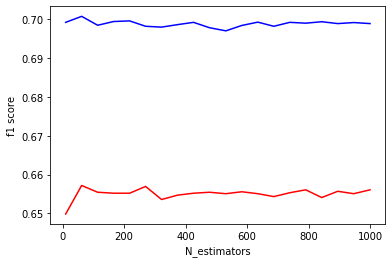

In [227]:
r = pd.DataFrame(res)
plt.plot(r.n_estimators, r.q_test, 'r')
plt.plot(r.n_estimators, r.q_train, 'b')
# plt.title("Зависимость качества на тесте от числа деревьев")
plt.xlabel('N_estimators')
plt.ylabel('f1 score')



### посмотрим, достаточный ли у нас объем выборки для обучения

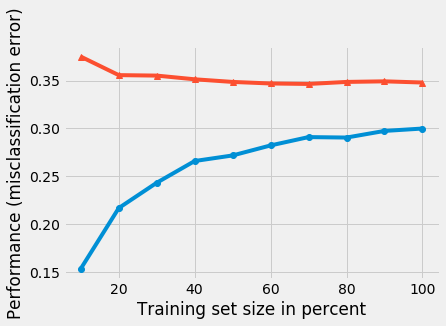

In [240]:
from mlxtend.plotting import plot_learning_curves
pl = Pipeline([
("preprocess", preprocessing_pipeline),
("model", RandomForestClassifier(n_estimators=12,  max_depth=10))
])
try:
    plot_learning_curves(X_train, y_train, X_test, y_test, pl)
except TypeError:
    pass

In [241]:
#данных вполне достаточно